In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import re, nltk      
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import geocoder
from collections import defaultdict, Counter
import copy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from math import exp
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/home/xujin/AI/anaconda2/lib/python2.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
#######
# based on http://www.cs.duke.edu/courses/spring14/compsci290/assignments/lab02.html
stemmer = PorterStemmer()
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    # remove non letters
    text = re.sub("[^a-zA-Z]", " ", text)
    # tokenize
    tokens = nltk.word_tokenize(text)
    # stem
    stems = stem_tokens(tokens, stemmer)
    return stems
######## 


def description_sentiment(sentences):
    analyzer = SentimentIntensityAnalyzer()
    result = []
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        result.append(vs)
    return pd.DataFrame(result).mean()

In [3]:
data_path = "../input/"
train_file = data_path + "train.json"
test_file = data_path + "test.json"
train_X = pd.read_json(train_file).reset_index(drop = True)
test_X = pd.read_json(test_file).reset_index(drop = True)
ntrain = train_X.shape[0]
print train_X.shape, test_X.shape, ntrain

(49352, 15) (74659, 14) 49352


In [4]:
interest_level_map = {'low': 0, 'medium': 1, 'high': 2}
train_y = train_X['interest_level'].apply(lambda x: interest_level_map[x]).values
print train_y.shape

(49352,)


In [5]:
train_test = pd.concat([train_X, test_X], 0).reset_index(drop = True)
print train_test.shape

(124011, 15)


In [6]:
# all features for train
feature_to_use = []
# features normalized by dividing max
norm_by_max = []
# features normalized by log
norm_by_log = []
# featuresnormalized by scaler
norm_by_scaler = []
# binary features
binary_features = []
# categorical feature
# cal_clos

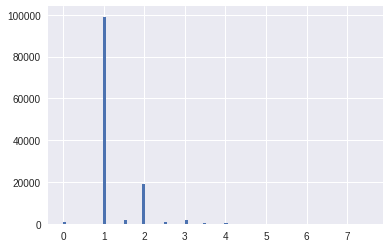

In [7]:
# bathrooms
train_test.loc[train_test.bathrooms == 10,['bathrooms']] = 1
train_test.loc[train_test.bathrooms == 20,['bathrooms']] = 2
train_test.loc[train_test.bathrooms == 112,['bathrooms']] = 1.5  
# train_test.loc[:,['bathrooms']] = train_test.loc[:,['bathrooms']] / train_test.loc[:,['bathrooms']].max()
train_test.bathrooms.hist(bins =100)

feature_to_use.append('bathrooms')
norm_by_max.append('bathrooms')

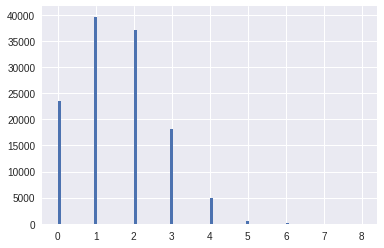

In [8]:
# bedrooms
# train_test.loc[:,['bedrooms']] = train_test.loc[:,['bedrooms']] / train_test.loc[:,['bedrooms']].max()
train_test.bedrooms.hist(bins =100)

feature_to_use.append('bedrooms')
norm_by_max.append('bedrooms')

In [9]:
# latitude longitude
train_test.loc[37395,'street_address'] = '452 E 78th St'
train_test.loc[87513,'street_address'] = '455 W 34th St'

missingCoords = train_test[(np.absolute(train_test.latitude - 41) > 3) | (np.absolute(train_test.longitude - -74) > 3)].index
# print missingCoords
missingGeoms = (train_test.loc[missingCoords, 'street_address'] + ', New York').apply(geocoder.google)
train_test.loc[missingCoords, 'longitude'] = missingGeoms.apply(lambda x: x.lng)
train_test.loc[missingCoords, 'latitude'] = missingGeoms.apply(lambda x: x.lat)

while (train_test.longitude.isnull().values.any() & train_test.latitude.isnull().values.any()):
    missingCoords = train_test[train_test.longitude.isnull() | train_test.latitude.isnull()].index
    print missingCoords
    missingGeoms = (train_test.loc[missingCoords, 'street_address'] + ', New York').apply(geocoder.google)
    train_test.loc[missingCoords, 'longitude'] = missingGeoms.apply(lambda x: x.lng)
    train_test.loc[missingCoords, 'latitude'] = missingGeoms.apply(lambda x: x.lat)
    
feature_to_use.extend(['longitude','latitude'])
norm_by_scaler.extend(['longitude','latitude'])
print 'Done!'

Done!


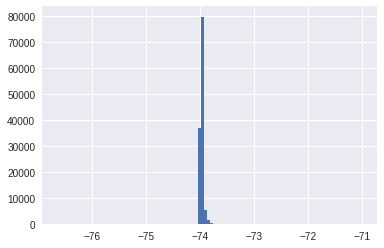

In [10]:
train_test.longitude.hist(bins = 100)

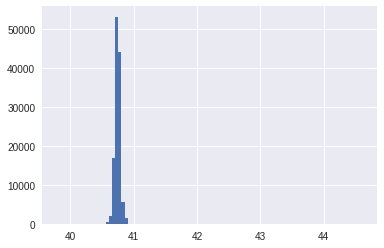

In [11]:
train_test.latitude.hist(bins = 100)

In [12]:
# building_id
# deal with '0'
train_test.loc[train_test['building_id'] == '0', 'building_id'] = \
    train_test.loc[train_test['building_id'] == '0', 'latitude'].astype(str) + \
    train_test.loc[train_test['building_id'] == '0', 'longitude'].astype(str)

lbl = preprocessing.LabelEncoder()
categorical = ["display_address", "manager_id", "building_id", "street_address"]
for f in categorical:
        if train_test[f].dtype=='object':
            train_test[f+'_lbl'] = lbl.fit_transform(train_test[f].values)
            feature_to_use.append(f+'_lbl')


cal_clos = ['display_address_lbl', 'manager_id_lbl', 'building_id_lbl', 'street_address_lbl']

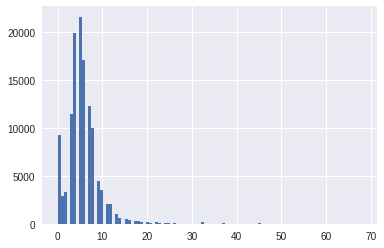

In [13]:
# count of photos #
train_test["num_photos"] = train_test["photos"].apply(len)
train_test.num_photos.hist(bins =100)

feature_to_use.append('num_photos')
norm_by_log = ['num_photos']

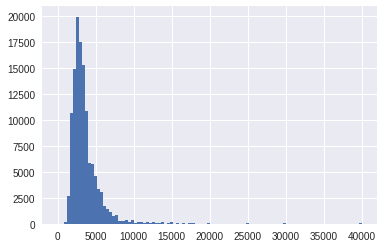

In [14]:
# price
train_test.loc[25538,'price'] = 1111.11
train_test.loc[(train_test.price >40000),'price'] = 40000
train_test.price.hist(bins =100)

feature_to_use.append('price')
norm_by_log.append('price')

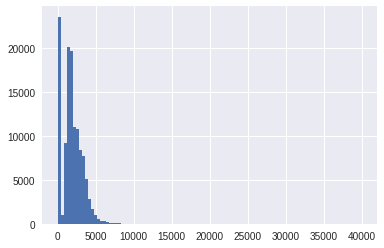

In [15]:
# pricePerBed
train_test['pricePerBed'] = (train_test['price'] / train_test['bedrooms'])\
    .apply(lambda x: -1 if (np.isinf(x) | np.isnan(x)) else x)
    
train_test.pricePerBed.hist(bins =100)

feature_to_use.append('pricePerBed')
norm_by_log.append('pricePerBed')

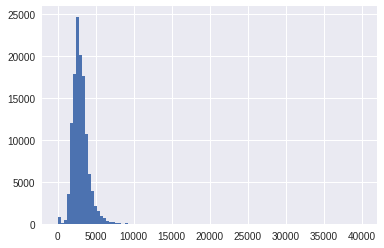

In [16]:
# pricePerBath
train_test['pricePerBath'] = (train_test['price'] / train_test['bathrooms'])\
    .apply(lambda x: -1 if (np.isinf(x) | np.isnan(x)) else x)
    
train_test.pricePerBath.hist(bins =100)

feature_to_use.append('pricePerBath')
norm_by_log.append('pricePerBath')

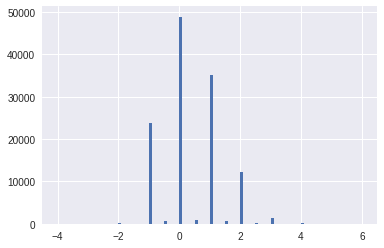

In [17]:
# bedBathDiff
train_test['bedBathDiff'] = (train_test['bedrooms'] - train_test['bathrooms'])

train_test.bedBathDiff.hist(bins =100)

feature_to_use.append('bedBathDiff')
norm_by_scaler.append('bedBathDiff')

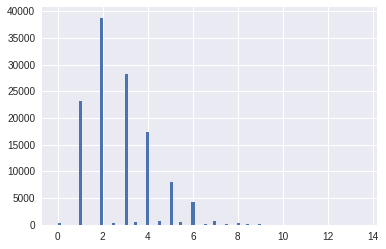

In [18]:
# bedBathSum
train_test['bedBathSum'] = (train_test['bedrooms'] + train_test['bathrooms'])
train_test.bedBathSum.hist(bins =100)

feature_to_use.append('bedBathSum')
norm_by_max.append('bedBathSum')

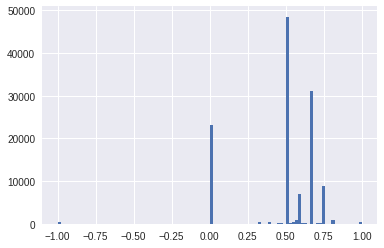

In [19]:
# bedsPerc
train_test['bedsPerc'] = (train_test['bedrooms'] / train_test['bedBathSum'])\
    .apply(lambda x: -1 if (np.isinf(x) | np.isnan(x)) else x)
    
train_test.bedsPerc.hist(bins =100)
feature_to_use.append('bedsPerc')
norm_by_scaler.append('bedsPerc')

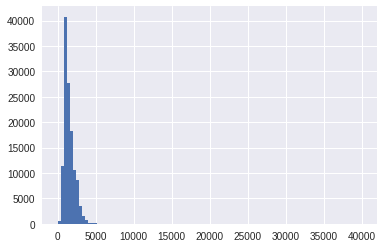

In [20]:
# pricePerRoom
train_test['pricePerRoom'] = (train_test['price'] / train_test['bedBathSum'])\
    .apply(lambda x: -1 if (np.isinf(x) | np.isnan(x)) else x)

train_test.pricePerRoom.hist(bins =100)

feature_to_use.append('pricePerRoom')
norm_by_log.append('pricePerRoom')

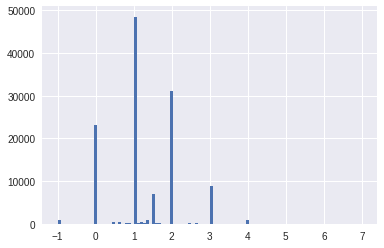

In [21]:
# bedPerBath
train_test['bedPerBath'] = (train_test['bedrooms'] / train_test['bathrooms'])\
    .apply(lambda x: -1 if (np.isinf(x) | np.isnan(x)) else x)
    
train_test.bedPerBath.hist(bins =100)
feature_to_use.append('bedPerBath')
norm_by_scaler.append('bedPerBath')

In [22]:
# Median price for bedroom 

def add_median_price(key=None, suffix="", train_test_df=None):
    # Set features to be used
    median_features = copy.copy(key)
    median_features.append('price')
    # Concat train and test to find median prices over whole dataset
    median_prices = train_test_df[median_features]
    # Group data by key to compute median prices
    medians_by_key = median_prices.groupby(by=key)['price'].median().reset_index()
    # Rename median column with provided suffix
    medians_by_key.rename(columns={'price': 'median_price_' + suffix}, inplace=True)
    # Update data frames, note that merge seems to reset the index
    # that's why I reset first and set again the index
    train_test_df = train_test_df.merge(medians_by_key, on=key, how='left')
    train_test_df['ratio_' + suffix] = train_test_df['price'] /train_test_df['median_price_' + suffix]

    return train_test_df

train_test = add_median_price(key=['bedrooms'],
                              suffix="bed",
                              train_test_df=train_test)

feature_to_use.extend(['median_price_bed','ratio_bed'])
norm_by_max.append('median_price_bed')
norm_by_log.append('ratio_bed')

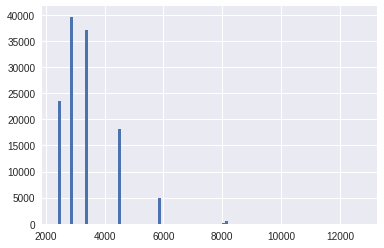

In [23]:
train_test.median_price_bed.hist(bins =100)

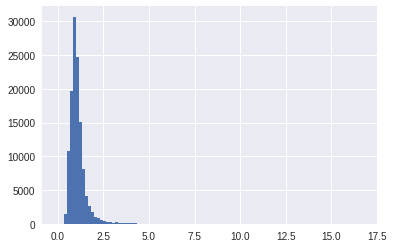

In [24]:
train_test.ratio_bed.hist(bins =100)

In [25]:
# It is lit by Branden

X_train = train_test[:ntrain]
X_test = train_test[ntrain:]

interest_level_map = {'low': 0, 'medium': 1, 'high': 2}
X_train['interest_level'] = X_train['interest_level'].apply(lambda x: interest_level_map[x])
X_test['interest_level'] = -1


low_count = len(X_train[X_train['interest_level'] == 0])
medium_count = len(X_train[X_train['interest_level'] == 1])
high_count = len(X_train[X_train['interest_level'] == 2])

def find_objects_with_only_one_record(feature_name):
    temp = pd.concat([X_train[feature_name].reset_index(), 
                      X_test[feature_name].reset_index()])
    temp = temp.groupby(feature_name, as_index = False).count()
    return temp[temp['index'] == 1]

managers_with_one_lot = find_objects_with_only_one_record('manager_id')
buildings_with_one_lot = find_objects_with_only_one_record('building_id')
addresses_with_one_lot = find_objects_with_only_one_record('display_address')

lambda_val = None
k=5.0
f=1.0
r_k=0.01 
g = 1.0

def categorical_average(variable, y, pred_0, feature_name):
    def calculate_average(sub1, sub2):
        s = pd.DataFrame(data = {
                                 variable: sub1.groupby(variable, as_index = False).count()[variable],                              
                                 'sumy': sub1.groupby(variable, as_index = False).sum()['y'],
                                 'avgY': sub1.groupby(variable, as_index = False).mean()['y'],
                                 'cnt': sub1.groupby(variable, as_index = False).count()['y']
                                 })
                                 
        tmp = sub2.merge(s.reset_index(), how='left', left_on=variable, right_on=variable) 
        del tmp['index']                       
        tmp.loc[pd.isnull(tmp['cnt']), 'cnt'] = 0.0
        tmp.loc[pd.isnull(tmp['cnt']), 'sumy'] = 0.0

        def compute_beta(row):
            cnt = row['cnt'] if row['cnt'] < 200 else float('inf')
            return 1.0 / (g + exp((cnt - k) / f))
            
        if lambda_val is not None:
            tmp['beta'] = lambda_val
        else:
            tmp['beta'] = tmp.apply(compute_beta, axis = 1)
            
        tmp['adj_avg'] = tmp.apply(lambda row: (1.0 - row['beta']) * row['avgY'] + row['beta'] * row['pred_0'],
                                   axis = 1)
                                   
        tmp.loc[pd.isnull(tmp['avgY']), 'avgY'] = tmp.loc[pd.isnull(tmp['avgY']), 'pred_0']
        tmp.loc[pd.isnull(tmp['adj_avg']), 'adj_avg'] = tmp.loc[pd.isnull(tmp['adj_avg']), 'pred_0']
        tmp['random'] = np.random.uniform(size = len(tmp))
        tmp['adj_avg'] = tmp.apply(lambda row: row['adj_avg'] *(1 + (row['random'] - 0.5) * r_k),
                                   axis = 1)
    
        return tmp['adj_avg'].ravel()
     
    #cv for training set 
    k_fold = StratifiedKFold(5)
    X_train[feature_name] = -999 
    for (train_index, cv_index) in k_fold.split(np.zeros(len(X_train)),
                                                X_train['interest_level'].ravel()):
        sub = pd.DataFrame(data = {variable: X_train[variable],
                                   'y': X_train[y],
                                   'pred_0': X_train[pred_0]})
            
        sub1 = sub.iloc[train_index]        
        sub2 = sub.iloc[cv_index]
        
        X_train.loc[cv_index, feature_name] = calculate_average(sub1, sub2)
    
    #for test set
    sub1 = pd.DataFrame(data = {variable: X_train[variable],
                                'y': X_train[y],
                                'pred_0': X_train[pred_0]})
    sub2 = pd.DataFrame(data = {variable: X_test[variable],
                                'y': X_test[y],
                                'pred_0': X_test[pred_0]})
    X_test.loc[:, feature_name] = calculate_average(sub1, sub2)                               

def transform_data(X):
  
    X['low'] = 0
    X.loc[X['interest_level'] == 0, 'low'] = 1
    X['medium'] = 0
    X.loc[X['interest_level'] == 1, 'medium'] = 1
    X['high'] = 0
    X.loc[X['interest_level'] == 2, 'high'] = 1
    
    X['pred0_low'] = low_count * 1.0 / ntrain
    X['pred0_medium'] = medium_count * 1.0 / ntrain
    X['pred0_high'] = high_count * 1.0 / ntrain
    
    X.loc[X['manager_id'].isin(managers_with_one_lot['manager_id'].ravel()), 
          'manager_id'] = "-1"
    X.loc[X['building_id'].isin(buildings_with_one_lot['building_id'].ravel()), 
          'building_id'] = "-1"
    X.loc[X['display_address'].isin(addresses_with_one_lot['display_address'].ravel()), 
          'display_address'] = "-1"
          
    return X

def normalize_high_cordiality_data():
    high_cardinality = ["building_id", "manager_id"]
    for c in high_cardinality:
        categorical_average(c, "medium", "pred0_medium", c + "_mean_medium")
        categorical_average(c, "high", "pred0_high", c + "_mean_high")

print "Starting transformations"         
X_train = transform_data(X_train)    
X_test = transform_data(X_test) 

print "Normalizing high cordiality data..." 
normalize_high_cordiality_data()


print "Merge data..." 
feature_high_cordianlity = ['building_id_mean_medium','building_id_mean_high', 
                            'manager_id_mean_medium','manager_id_mean_high','listing_id']
train_test_high_cordianlity = pd.concat([X_train[feature_high_cordianlity], X_test[feature_high_cordianlity]], 0)
train_test = train_test.merge(train_test_high_cordianlity, on = 'listing_id', how = 'left')
del X_train,X_test
print 'Done!'

feature_to_use.extend(feature_high_cordianlity)
norm_by_scaler.extend(['building_id_mean_medium','building_id_mean_high', 
                            'manager_id_mean_medium','manager_id_mean_high'])
cal_clos.append('listing_id')

Starting transformations
Normalizing high cordiality data...
Merge data...
Done!


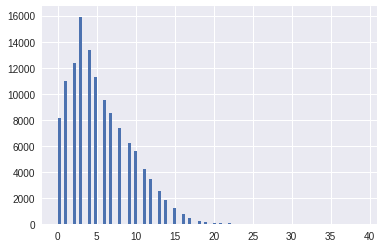

In [26]:
# count of "features" #
train_test["num_features"] = train_test["features"].apply(len)
train_test.num_features.hist(bins =100)

feature_to_use.append('num_features')
norm_by_log.append('num_features')

In [27]:
# created date
# convert the created column to datetime object so as to extract more features 
train_test["created"] = pd.to_datetime(train_test["created"])

# Let us extract some features like weekday, month, day, hour from date columns #
train_test["created_month"] = train_test["created"].dt.month
train_test["created_day"] = train_test["created"].dt.day
train_test["created_weekday"] = train_test["created"].dt.weekday
train_test["created_hour"] = train_test["created"].dt.hour
train_test["created_dayofyear"] = train_test["created"].dt.dayofyear
feature_to_use.extend(['created_month','created_day','created_weekday','created_hour',"created_dayofyear"])
norm_by_scaler.extend(['created_month','created_day','created_weekday','created_hour',"created_dayofyear"])

In [28]:
# address
import string

train_test['address1'] = train_test['display_address']
train_test['address1'] = train_test['address1'].apply(lambda x: x.lower())

address_map = {
    'w': 'west',
    'st.': 'street',
    'ave': 'avenue',
    'st': 'street',
    'e': 'east',
    'n': 'north',
    's': 'south'
}


def address_map_func(s):
    s = s.split(' ')
    out = []
    for x in s:
        if x in address_map:
            out.append(address_map[x])
        else:
            out.append(x)
    return ' '.join(out)

string.punctuation.__add__('!!')
string.punctuation.__add__('(')
string.punctuation.__add__(')')

remove_punct_map = dict.fromkeys(map(ord, string.punctuation))


train_test['address1'] = train_test['address1'].apply(lambda x: x.translate(remove_punct_map))
train_test['address1'] = train_test['address1'].apply(lambda x: address_map_func(x))

new_cols = ['street', 'avenue', 'east', 'west', 'north', 'south']

for col in new_cols:
    train_test[col] = train_test['address1'].apply(lambda x: 1 if col in x else 0)

train_test['other_address'] = train_test[new_cols].apply(lambda x: 1 if x.sum() == 0 else 0, axis=1)


feature_to_use.extend(['street', 'avenue', 'east', 'west', 'north', 'south','other_address'])
binary_features.extend(['street', 'avenue', 'east', 'west', 'north', 'south','other_address'])
print 'Done!'

Done!


In [29]:
managers_count = train_test['manager_id_lbl'].value_counts()

train_test['top_10_manager'] = train_test['manager_id_lbl'].apply(lambda x: 1 if x in managers_count.index.values[
    managers_count.values >= np.percentile(managers_count.values, 90)] else 0)
train_test['top_25_manager'] = train_test['manager_id_lbl'].apply(lambda x: 1 if x in managers_count.index.values[
    managers_count.values >= np.percentile(managers_count.values, 75)] else 0)
train_test['top_5_manager'] = train_test['manager_id_lbl'].apply(lambda x: 1 if x in managers_count.index.values[
    managers_count.values >= np.percentile(managers_count.values, 95)] else 0)
train_test['top_50_manager'] = train_test['manager_id_lbl'].apply(lambda x: 1 if x in managers_count.index.values[
    managers_count.values >= np.percentile(managers_count.values, 50)] else 0)
train_test['top_1_manager'] = train_test['manager_id_lbl'].apply(lambda x: 1 if x in managers_count.index.values[
    managers_count.values >= np.percentile(managers_count.values, 99)] else 0)
train_test['top_2_manager'] = train_test['manager_id_lbl'].apply(lambda x: 1 if x in managers_count.index.values[
    managers_count.values >= np.percentile(managers_count.values, 98)] else 0)
train_test['top_15_manager'] = train_test['manager_id_lbl'].apply(lambda x: 1 if x in managers_count.index.values[
    managers_count.values >= np.percentile(managers_count.values, 85)] else 0)
train_test['top_20_manager'] = train_test['manager_id_lbl'].apply(lambda x: 1 if x in managers_count.index.values[
    managers_count.values >= np.percentile(managers_count.values, 80)] else 0)
train_test['top_30_manager'] = train_test['manager_id_lbl'].apply(lambda x: 1 if x in managers_count.index.values[
    managers_count.values >= np.percentile(managers_count.values, 70)] else 0)

feature_to_use.extend(['top_10_manager','top_25_manager','top_5_manager','top_50_manager','top_1_manager',
                       'top_2_manager','top_15_manager','top_20_manager','top_30_manager'])

binary_features.extend(['top_10_manager','top_25_manager','top_5_manager','top_50_manager','top_1_manager',
                       'top_2_manager','top_15_manager','top_20_manager','top_30_manager'])

In [30]:
buildings_count = train_test['building_id_lbl'].value_counts()

train_test['top_10_building'] = train_test['building_id_lbl'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 90)] else 0)
train_test['top_25_building'] = train_test['building_id_lbl'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 75)] else 0)
train_test['top_5_building'] = train_test['building_id_lbl'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 95)] else 0)
train_test['top_50_building'] = train_test['building_id_lbl'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 50)] else 0)
train_test['top_1_building'] = train_test['building_id_lbl'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 99)] else 0)
train_test['top_2_building'] = train_test['building_id_lbl'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 98)] else 0)
train_test['top_15_building'] = train_test['building_id_lbl'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 85)] else 0)
train_test['top_20_building'] = train_test['building_id_lbl'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 80)] else 0)
train_test['top_30_building'] = train_test['building_id_lbl'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 70)] else 0)

feature_to_use.extend(['top_10_building','top_25_building','top_5_building','top_50_building','top_1_building',
                       'top_2_building','top_15_building','top_20_building','top_30_building'])
binary_features.extend(['top_10_building','top_25_building','top_5_building','top_50_building','top_1_building',
                       'top_2_building','top_15_building','top_20_building','top_30_building'])

In [31]:
# sparse features

train_test['clean_features'] = train_test['features'].apply(lambda x: [t.replace('*', ', ') for t in x])
train_test['clean_features'] = train_test['clean_features'].apply(lambda x: [t.replace('!', ', ') for t in x])
train_test['clean_features'] = train_test['clean_features'].apply(lambda x: [t.replace('&', ', ') for t in x])
train_test['clean_features'] = train_test['clean_features'].apply(lambda x: [t.replace(', ,', ', ') for t in x])

features = train_test["clean_features"].apply(lambda x: [i.lower() for i in x])

# count features and drop features with less than n counts
n = 5
feature_counts = Counter()
for feature in features.values:
    feature_counts.update(feature)
feature = sorted([k for (k,v) in feature_counts.items() if v > n])

def clean(s):
    x = s.replace("-", "")
    x = x.replace(" ", "")
    x = x.replace("*", "")
    x = x.replace("1monthfree", "onemonthfree")
    x = x.replace("2fullbaths", "wfba")
    x = x.replace("$250", "wfty")
    x = x.replace("twentyfourhour", "tf")
    x = x.replace("24/7", "tf")
    x = x.replace("24hr", "tf")
    x = x.replace("24-hour", "tf")
    x = x.replace("24hour", "tf")
    x = x.replace("24 hour", "tf")
    x = x.replace("attended", "")
    x = x.replace("assigned", "")
    x = x.replace("buildingcommon", "")
    x = x.replace("a/c", "ac")
    x = x.replace("children's", "childrens")
    x = x.replace("common", "cm")
    x = x.replace("concierge", "doorman")
    x = x.replace("bicycle", "bike")
    x = x.replace("private", "pv")
    x = x.replace("decorative", "dc")
    x = x.replace("deco", "dc")    
    x = x.replace("fireplaces", "fireplace")
    x = x.replace("gym", "fitness")
    x = x.replace("inunit", "") 
    x = x.replace("dryer", "washer")       
    x = x.replace("onsite", "")
    x = x.replace("outdoor", "od")
    x = x.replace("ssappliances", "stainless")
    x = x.replace("s/sappliances", "stainless")
    x = x.replace("full", "fl")
    x = x.replace("fully", "fl")
    x = x.replace("high", "hi")    
    x = x.replace("parking", "pkng")
    x = x.replace("shares", "share")
    x = x.replace("share", "sr")
    x = x.replace("stateoftheart", "")
    x = x.replace("tonsof", "")
    x = x.replace("petfriendly", "pets")
    x = x.replace("allpetsok", "pets")
    x = x.replace("atmmachine", "atm")
    x = x.replace("party", "pty")
    x = x.replace("swimming", "")
    x = x.replace("valet", "vt")
    x = x.replace("closeto", "cto")

    return x

key2original = defaultdict(list)
k = 4
for f in feature:
    cleaned = clean(f)
    key = cleaned[:k].strip()
    key2original[key].append(f)

def clean_feature(y):
    key = clean(y)[:k].strip()
#     print key
    if key in key2original.keys():
        return key
    else:
        return y   

train_test["clean_features"] = features.apply(lambda x: [clean_feature(i) for i in x]) #203 features



In [48]:
print 'Counting Vectorizer...'

def tokenize1(text):
    # remove non letters
    text = re.sub("[^a-zA-Z]", " ", text)
    # tokenize
    tokens = nltk.word_tokenize(text)
#     # stem
#     stems = stem_tokens(tokens, stemmer)

    stems = tokens
    return stems

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize1,
    lowercase = True,
    stop_words = 'english',
    max_features = 200
)

tmp = train_test.clean_features.apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
feat_sparse = vectorizer.fit_transform(tmp)
feature_sparse_cols = ['feature_' + x for x in vectorizer.get_feature_names()]
print 'Done!'

Counting Vectorizer...
Done!


In [50]:
train_test['feature_upper_perc'] = train_test["features"]\
    .apply(lambda x: " ".join([" ".join(i.split(" ")) for i in x]))\
    .apply(lambda x: -1 if (sum(1 for c in x if c.isalpha()) == 0) \
           else sum(1.0 for c in x if c.isupper()) / sum(1.0 for c in x if c.isalpha()))
    
feature_to_use.append('feature_upper_perc')
norm_by_scaler.append('feature_upper_perc')

In [51]:
# count of words present in description column #
train_test['clean_description'] = train_test['description'].apply(lambda x: x.replace('<p>', ' '))
train_test['clean_description'] = train_test['clean_description'].apply(lambda x: x.replace('<a', ' '))
train_test['clean_description'] = train_test['clean_description'].apply(lambda x: x.replace('website_redacted', ' ')) 
train_test['clean_description'] = train_test['clean_description'].apply(lambda x: x.replace(u"\u2022", '.'))
train_test['clean_description'] = train_test['clean_description'].apply(lambda x: x.replace('<br />', ' '))
train_test['clean_description'] = train_test['clean_description'].apply(lambda x: x.replace('<br/>', ' '))
train_test['clean_description'] = train_test['clean_description'].apply(lambda x: x.replace('&amp;', ' '))
train_test['clean_description'] = train_test['clean_description'].apply(lambda x: x.replace('*', ' '))

train_test['clean_description'] = train_test['clean_description'].apply(lambda x: x.replace('</p>', ' '))
train_test['clean_description'] = train_test['clean_description'].apply(lambda x: x.replace('<div>', ' ')) 
train_test['clean_description'] = train_test['clean_description'].apply(lambda x: x.replace('</div>', ' '))
train_test['clean_description'] = train_test['clean_description'].apply(lambda x: x.replace('<u>', ' '))
train_test['clean_description'] = train_test['clean_description'].apply(lambda x: x.replace('</u>', ' '))
train_test['clean_description'] = train_test['clean_description'].apply(lambda x: x.replace('<ul>', ' '))
train_test['clean_description'] = train_test['clean_description'].apply(lambda x: x.replace('</ul>', ' '))
train_test['clean_description'] = train_test['clean_description'].apply(lambda x: x.replace('<li>', ' ')) 
train_test['clean_description'] = train_test['clean_description'].apply(lambda x: x.replace('</li>', '.'))
train_test['clean_description'] = train_test['clean_description']\
    .apply(lambda x: x.replace('<span style="color: rgb(255, 0, 0); ">', ' '))
train_test['clean_description'] = train_test['clean_description'].apply(lambda x: x.replace('<span>', ' '))
train_test['clean_description'] = train_test['clean_description'].apply(lambda x: x.replace('</span>', ' '))
train_test['clean_description'] = train_test['clean_description'].apply(lambda x: x.replace('</strong>', ' '))
train_test['clean_description'] = train_test['clean_description'].apply(lambda x: x.replace('<strong>', ' '))
train_test['clean_description'] = train_test['clean_description'].apply(lambda x: x.replace('nbsp;', ' '))
train_test['clean_description'] = train_test['clean_description'].apply(lambda x: x.replace('</BR>', ' '))
train_test['clean_description'] = train_test['clean_description'].apply(lambda x: x.replace('<BR>', ' '))
train_test['clean_description'] = train_test['clean_description'].apply(lambda x: x.replace('</em>', ' '))
train_test['clean_description'] = train_test['clean_description'].apply(lambda x: x.replace('<em>', ' '))
train_test['clean_description'] = train_test['clean_description'].apply(lambda x: x.replace('--', ' '))
train_test['clean_description'] = train_test['clean_description'].apply(lambda x: x.replace('\r', '.'))
train_test['clean_description'] = train_test['clean_description'].apply(lambda x: x.replace('-', ' '))
train_test['clean_description'] = train_test['clean_description']\
    .apply(lambda x: x.replace('<img src= "   width="1" height="1" />', ' '))
train_test['clean_description'] = train_test['clean_description'].apply(lambda x: x.replace(';', '.'))
train_test['clean_description'] = train_test['clean_description'].apply(lambda x: x.replace('.', '. '))


#==============================
train_test['description_tokens'] = train_test['clean_description'].apply(sent_tokenize)
train_test['num_description_sent'] = train_test['description_tokens'].apply(len)


train_test['num_description_words'] = train_test['clean_description']\
                                        .apply(lambda x: 0 if len(x.strip()) == 0 else len(x.split(' ')))


train_test['word_sent_desc'] = train_test['num_description_words'] / train_test['num_description_sent']


train_test = pd.concat([train_test,train_test['description_tokens']\
                      .apply(description_sentiment)],axis=1)
train_test.fillna(-1, inplace=True)

train_test['desc_upper_perc'] = train_test.clean_description\
    .apply(lambda x: -1 if (sum(1 for c in x if c.isalpha()) == 0) \
           else sum(1.0 for c in x if c.isupper()) / sum(1.0 for c in x if c.isalpha()))

feature_to_use.extend(['num_description_sent','num_description_words',
                       'word_sent_desc', 'compound', 'neg', 'neu', 'pos', 'desc_upper_perc'])
norm_by_log.extend(['num_description_sent','num_description_words','word_sent_desc'])
norm_by_scaler.extend(['compound', 'neg', 'neu', 'pos','desc_upper_perc'])

print 'Done!'

Done!


In [52]:
vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    stop_words = 'english',
    max_features = 200
)

tmp = train_test.clean_description
desc_sparse = vectorizer.fit_transform(tmp)
desc_sparse_cols = ['desc_' + x for x in vectorizer.get_feature_names()]
print 'Done!'

Done!


In [72]:
feat_dense = pd.DataFrame(feat_sparse.toarray(), columns=feature_sparse_cols)
desc_dense = pd.DataFrame(desc_sparse.toarray(), columns=desc_sparse_cols)

In [73]:
full_data = pd.DataFrame(np.hstack([train_test[feature_to_use],feat_dense,desc_dense]),columns=[feature_to_use + feature_sparse_cols + desc_sparse_cols])

In [74]:
train_X = full_data[:ntrain]
test_X = full_data[ntrain:]
print train_X.shape
print test_X.shape

(49352, 464)
(74659, 464)


In [75]:
train_X.to_pickle(data_path + 'train_X_0319.pkl')
test_X.to_pickle(data_path + 'test_X_0319.pkl')
pd.DataFrame(train_y).to_pickle(data_path + 'train_y_0319.pkl')

In [3]:
data_path = "../input/"
re_train_X = pd.read_pickle(data_path + 'train_X_0319.pkl')
re_test_X = pd.read_pickle(data_path + 'test_X_0319.pkl')

In [86]:
re_full_data = pd.concat([train_X,test_X])
print re_full_data.shape

(124011, 464)


In [89]:
# features normalized by dividing max
norm_by_max
# 4

['bathrooms', 'bedrooms', 'bedBathSum', 'median_price_bed']

In [90]:
for col in norm_by_max:
    print re_full_data[col].max()
    re_full_data[col] = re_full_data[col] / re_full_data[col].max()

7.5
8.0
13.5
12750.0


In [91]:
# features normalized by log
norm_by_log
# 10

['num_photos',
 'price',
 'pricePerBed',
 'pricePerBath',
 'pricePerRoom',
 'ratio_bed',
 'num_features',
 'num_description_sent',
 'num_description_words',
 'word_sent_desc']

In [92]:
scaler = preprocessing.StandardScaler()
for col in norm_by_log:
    print col
    re_full_data[col] = np.log(re_full_data[col].values+3)
    re_full_data[col] = scaler.fit_transform(re_full_data[col])

num_photos
price
pricePerBed
pricePerBath
pricePerRoom
ratio_bed
num_features
num_description_sent
num_description_words
word_sent_desc


In [93]:
# featuresnormalized by scaler
norm_by_scaler 
# 20

['longitude',
 'latitude',
 'bedBathDiff',
 'bedsPerc',
 'bedPerBath',
 'building_id_mean_medium',
 'building_id_mean_high',
 'manager_id_mean_medium',
 'manager_id_mean_high',
 'created_month',
 'created_day',
 'created_weekday',
 'created_hour',
 'created_dayofyear',
 'feature_upper_perc',
 'compound',
 'neg',
 'neu',
 'pos',
 'desc_upper_perc']

In [94]:
for col in norm_by_scaler:
    print col
    re_full_data[col] = scaler.fit_transform(re_full_data[col])

longitude
latitude
bedBathDiff
bedsPerc
bedPerBath
building_id_mean_medium
building_id_mean_high
manager_id_mean_medium
manager_id_mean_high
created_month
created_day
created_weekday
created_hour
created_dayofyear
feature_upper_perc
compound
neg
neu
pos
desc_upper_perc


In [95]:
for col in feature_sparse_cols:
#     print col, re_full_data[col].max()
    re_full_data[col] = (re_full_data[col] / re_full_data[col].max())\
        .apply(lambda x: 0 if (np.isinf(x) | np.isnan(x)) else x)

In [96]:
for col in desc_sparse_cols:
#     print col, re_full_data[col].max()
    re_full_data[col] = (re_full_data[col] / re_full_data[col].max())\
        .apply(lambda x: 0 if (np.isinf(x) | np.isnan(x)) else x)

In [97]:
# binary features
binary_features
# 25

['street',
 'avenue',
 'east',
 'west',
 'north',
 'south',
 'other_address',
 'top_10_manager',
 'top_25_manager',
 'top_5_manager',
 'top_50_manager',
 'top_1_manager',
 'top_2_manager',
 'top_15_manager',
 'top_20_manager',
 'top_30_manager',
 'top_10_building',
 'top_25_building',
 'top_5_building',
 'top_50_building',
 'top_1_building',
 'top_2_building',
 'top_15_building',
 'top_20_building',
 'top_30_building']

In [98]:
cal_clos
# 5

['display_address_lbl',
 'manager_id_lbl',
 'building_id_lbl',
 'street_address_lbl',
 'listing_id']

In [99]:
UniqueID = re_full_data.listing_id.values

In [100]:
UniqueID

array([ 7211212.,  7150865.,  6887163., ...,  6882352.,  6884758.,
        6924212.])

In [101]:
for col in cal_clos:
#     print col, re_full_data[col].max()
    re_full_data[col] = scaler.fit_transform(re_full_data[col])

In [102]:
train_X = re_full_data[:ntrain]
test_X = re_full_data[ntrain:]
train_id = pd.DataFrame(UniqueID[:ntrain])
test_id = pd.DataFrame(UniqueID[ntrain:])
print train_X.shape
print test_X.shape
print train_id.shape
print test_id.shape

train_X.to_pickle(data_path + 'train_X_norm_0319.pkl')
test_X.to_pickle(data_path + 'test_X_norm_0319.pkl')
train_id.to_pickle(data_path + 'train_id_0319.pkl')
test_id.to_pickle(data_path + 'test_id_0319.pkl')

(49352, 464)
(74659, 464)
(49352, 1)
(74659, 1)
